# Crime in Boston

## 1) Data Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn import tree

#from ggplot import *

# for tree -
#pip install -c anaconda python-graphviz

from sklearn.tree import export_graphviz

from sklearn.metrics import classification_report,confusion_matrix

from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier

#for xgboost -
#pip install xgboost

# for ggplot -
#pip install ggplot

from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score

from sklearn.model_selection import KFold

import geopandas as gpd
import math

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

#foR report
#conda install -c conda-forge pandas-profiling

#conda install pandas=0.20.3


%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

In [2]:
#https://www.kaggle.com/AnalyzeBoston/crimes-in-boston
cb = pd.read_csv('crime.csv',encoding='latin_1')
cb.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [3]:
# Rename columns to something easier to type (the all-caps are annoying!)
rename = {'INCIDENT_NUMBER':'Incident_Number',
         'OFFENSE_CODE':'Code',
         'OFFENSE_CODE_GROUP':'Group',
         'OFFENSE_DESCRIPTION':'Description',
         'DISTRICT':'District',
         'REPORTING_AREA':'Area',
         'SHOOTING':'Shooting',
         'OCCURRED_ON_DATE':'Date',
         'YEAR':'Year',
         'MONTH':'Month',
         'DAY_OF_WEEK':'Day',
         'HOUR':'Hour',
         'STREET':'Street'}
cb.rename(index=str, columns=rename, inplace=True)

# Remove unused columns
cb = cb.drop(['Incident_Number','Code','UCR_PART','Location'], axis=1)

# Convert OCCURED_ON_DATE to datetime
cb['Date'] = pd.to_datetime(cb['Date'])

# Fill in nans in SHOOTING column
cb.Shooting.fillna('N', inplace=True)

# Convert DAY_OF_WEEK to an ordered category
cb.Day = pd.Categorical(cb.Day, 
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)

cb.head()

,Group,Description,District,Area,Shooting,Date,Year,Month,Day,Hour,Street,Lat,Long
0,Larceny,LARCENY ALL OTHERS,D14,808,N,2018-09-02 13:00:00,2018,9,Sunday,13,LINCOLN ST,42.357791,-71.139371
1,Vandalism,VANDALISM,C11,347,N,2018-08-21 00:00:00,2018,8,Tuesday,0,HECLA ST,42.306821,-71.060300
2,Towed,TOWED MOTOR VEHICLE,D4,151,N,2018-09-03 19:27:00,2018,9,Monday,19,CAZENOVE ST,42.346589,-71.072429
3,Investigate Property,INVESTIGATE PROPERTY,D4,272,N,2018-09-03 21:16:00,2018,9,Monday,21,NEWCOMB ST,42.334182,-71.078664
4,Investigate Property,INVESTIGATE PROPERTY,B3,421,N,2018-09-03 21:05:00,2018,9,Monday,21,DELHI ST,42.275365,-71.090361


## 2) Data Analysis

In [4]:
cb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 319073 entries, 0 to 319072
Data columns (total 13 columns):
Group          319073 non-null object
Description    319073 non-null object
District       317308 non-null object
Area           319073 non-null object
Shooting       319073 non-null object
Date           319073 non-null datetime64[ns]
Year           319073 non-null int64
Month          319073 non-null int64
Day            319073 non-null category
Hour           319073 non-null int64
Street         308202 non-null object
Lat            299074 non-null float64
Long           299074 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 32.0+ MB


In [5]:
cb.describe(include='all')

,Group,Description,District,Area,Shooting,Date,Year,Month,Day,Hour,Street,Lat,Long
count,319073,319073,317308,319073,319073,319073,319073.000000,319073.000000,319073,319073.000000,308202,299074.000000,299074.000000
unique,67,244,12,879,2,233229,NaN,NaN,7,NaN,4657,NaN,NaN
top,Motor Vehicle Accident Response,SICK/INJURED/MEDICAL - PERSON,B2,,N,2017-06-01 00:00:00,NaN,NaN,Friday,NaN,WASHINGTON ST,NaN,NaN
freq,37132,18783,49945,20250,318054,29,NaN,NaN,48495,NaN,14194,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,2015-06-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2018-09-03 21:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2016.560586,6.609719,NaN,13.118205,NaN,42.214381,-70.908272
std,NaN,NaN,NaN,NaN,NaN,NaN,0.996344,3.273691,NaN,6.294205,NaN,2.159766,3.493618
min,NaN,NaN,NaN,NaN,NaN,NaN,2015.000000,1.000000,NaN,0.000000,NaN,-1.000000,-71.178674
25%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,4.000000,NaN,9.000000,NaN,42.297442,-71.097135


In [6]:
cb.describe()

,Year,Month,Hour,Lat,Long
count,319073.000000,319073.000000,319073.000000,299074.000000,299074.000000
mean,2016.560586,6.609719,13.118205,42.214381,-70.908272
std,0.996344,3.273691,6.294205,2.159766,3.493618
min,2015.000000,1.000000,0.000000,-1.000000,-71.178674
25%,2016.000000,4.000000,9.000000,42.297442,-71.097135
50%,2017.000000,7.000000,14.000000,42.325538,-71.077524
75%,2017.000000,9.000000,18.000000,42.348624,-71.062467
max,2018.000000,12.000000,23.000000,42.395042,-1.000000


In [7]:
cb[["Group","Year"]].groupby(['Group'], as_index=False).count().sort_values(by='Year', ascending=False)

,Group,Year
43,Motor Vehicle Accident Response,37132
34,Larceny,25935
40,Medical Assistance,23540
31,Investigate Person,18750
46,Other,18075
15,Drug Violation,16548
61,Simple Assault,15826
63,Vandalism,15415
64,Verbal Disputes,13099
62,Towed,11287


In [8]:
cb.groupby('Group').agg({
    'Hour':['count','sum','mean']
})

Hour                   
                                           count     sum       mean
Group                                                              
Aggravated Assault                          7807  101034  12.941463
Aircraft                                      36     527  14.638889
Arson                                         94    1030  10.957447
Assembly or Gathering Violations             955   10218  10.699476
Auto Theft                                  4851   66375  13.682746
Auto Theft Recovery                         1051   13229  12.587060
Ballistics                                   981   12433  12.673802
Biological Threat                              2      23  11.500000
Bomb Hoax                                     75     956  12.746667
Burglary - No Property Taken                   2      25  12.500000
Commercial Burglary                         1337   13213   9.882573
Confidence Games                            3147   36751  11.678106
Counterfeiting                              1454   18571  12.772352
Criminal Harassment                          131    1671  12.755725
Disorderly Conduct                          2611   31059  11.895442
Drug Violation                             16548  242583  14.659355
Embezzlement                                 296    3578  12.087838
Evading Fare                                 407    5032  12.363636
Explosives                                    27     273  10.111111
Fire Related Reports                        1920   24922  12.980208
Firearm Discovery                            698    8987  12.875358
Firearm Violations                          1777   23091  12.994373
Fraud                                       5829   69939  11.998456
Gambling                                       8     104  13.000000
HOME INVASION                                 77     905  11.753247
HUMAN TRAFFICKING                              7      86  12.285714
HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE      2      26  13.000000
Harassment                                  4007   53129  13.259047
Harbor Related Incidents                     212    2912  13.735849
Homicide                                     161    2139  13.285714
INVESTIGATE PERSON                             4      60  15.000000
Investigate Person                         18750  253842  13.538240
Investigate Property                       11124  142028  12.767709
Landlord/Tenant Disputes                     968   13273  13.711777
Larceny                                    25935  354422  13.665780
Larceny From Motor Vehicle                 10847  148039  13.647921
License Plate Related Incidents              560    7223  12.898214
License Violation                           1701   19679  11.569077
Liquor Violation                            1052   14228  13.524715
Manslaughter                                   8      72   9.000000
Medical Assistance                         23540  306999  13.041589
Missing Person Located                      4958   67722  13.659137
Missing Person Reported                     3797   51457  13.552015
Motor Vehicle Accident Response            37132  490068  13.197996
Offenses Against Child / Family              545    7193  13.198165
Operating Under the Influence                574    6150  10.714286
Other                                      18075  235076  13.005588
Other Burglary                               461    5841  12.670282
Phone Call Complaints                         31     313  10.096774
Police Service Incidents                    2781   33165  11.925566
Prisoner Related Incidents                   253    3101  12.256917
Property Found                              3925   51162  13.034904
Property Lost                               9751  128571  13.185417
Property Related Damage                      912   11699  12.827851
Prostitution                                 207    2457  11.869565
Recovered Stolen Property                   1455   18333  12.600000
Residential Burglary            

In [9]:
percent = cb[["Group","Year"]].groupby(['Group'], as_index=False).count().sort_values(by='Year', ascending=False)
percent['Year']= percent['Year']/percent['Year'].sum()
print(percent)

                                        Group      Year
43            Motor Vehicle Accident Response  0.116375
34                                    Larceny  0.081282
40                         Medical Assistance  0.073776
31                         Investigate Person  0.058764
46                                      Other  0.056648
15                             Drug Violation  0.051863
61                             Simple Assault  0.049600
63                                  Vandalism  0.048312
64                            Verbal Disputes  0.041053
62                                      Towed  0.035374
32                       Investigate Property  0.034863
35                 Larceny From Motor Vehicle  0.033995
52                              Property Lost  0.030560
66                            Warrant Arrests  0.026348
0                          Aggravated Assault  0.024468
65                                 Violations  0.019102
22                                      Fraud  0

## 3) Data Visualization

Text(0, 0.5, 'Number of Crimes')

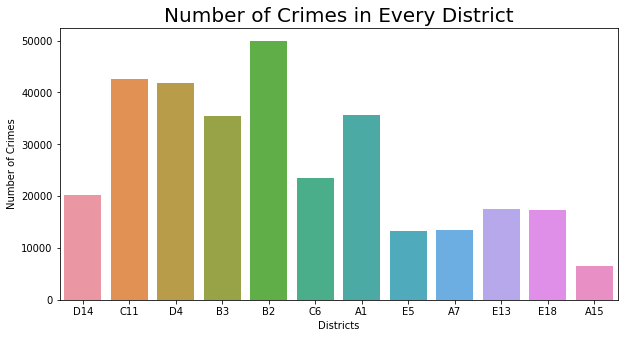

In [10]:
#Crimes in every District from 2015-2018
plt.figure(figsize=(10,5)) #to adjust the graph size
sns.countplot(x='District',data=cb )
plt.title('Number of Crimes in Every District',fontsize=20)
plt.xlabel('Districts')
plt.ylabel('Number of Crimes')

Text(0, 0.5, 'Number of Crimes')

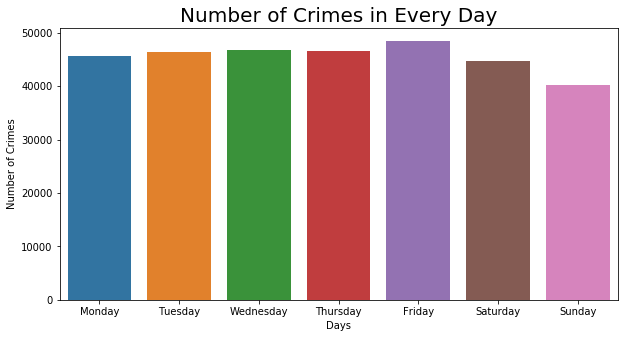

In [11]:
#Crimes in every Days
plt.figure(figsize=(10,5)) #to adjust the graph size
sns.countplot(x='Day',data=cb)
plt.title('Number of Crimes in Every Day',fontsize=20)
plt.xlabel('Days')
plt.ylabel('Number of Crimes')

Text(0, 0.5, 'Number of Crimes')

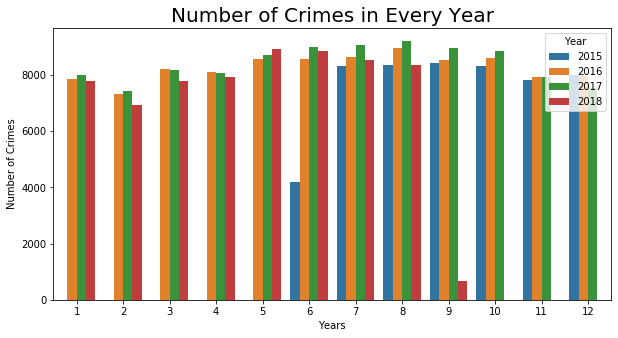

In [12]:
#Crimes in every Year
plt.figure(figsize=(10,5)) #to adjust the graph size
sns.countplot(x='Month',data=cb, hue='Year')
plt.title('Number of Crimes in Every Year',fontsize=20)
plt.xlabel('Years')
plt.ylabel('Number of Crimes')

Text(0, 0.5, 'Number of Crimes')

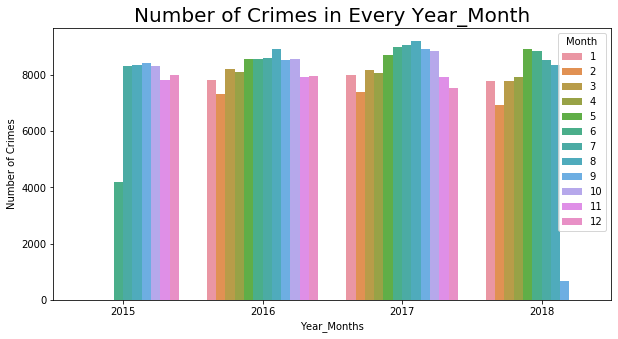

In [13]:
#Crimes in every Year_Month
plt.figure(figsize=(10,5)) #to adjust the graph size
sns.countplot(x='Year',data=cb, hue='Month')
plt.title('Number of Crimes in Every Year_Month',fontsize=20)
plt.xlabel('Year_Months')
plt.ylabel('Number of Crimes')

Text(0, 0.5, 'Number of Crimes')

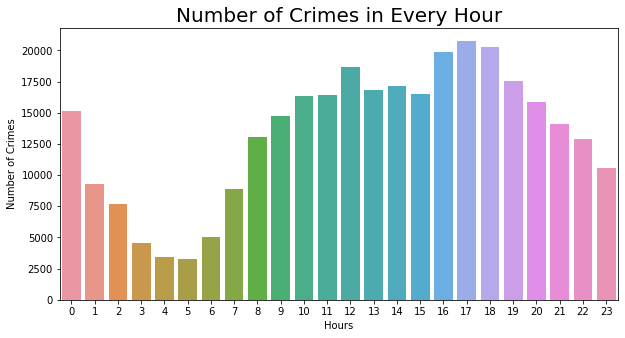

In [14]:
#Crimes in every Hours
plt.figure(figsize=(10,5)) #to adjust the graph size
sns.countplot(x='Hour',data=cb)
plt.title('Number of Crimes in Every Hour',fontsize=20)
plt.xlabel('Hours')
plt.ylabel('Number of Crimes')

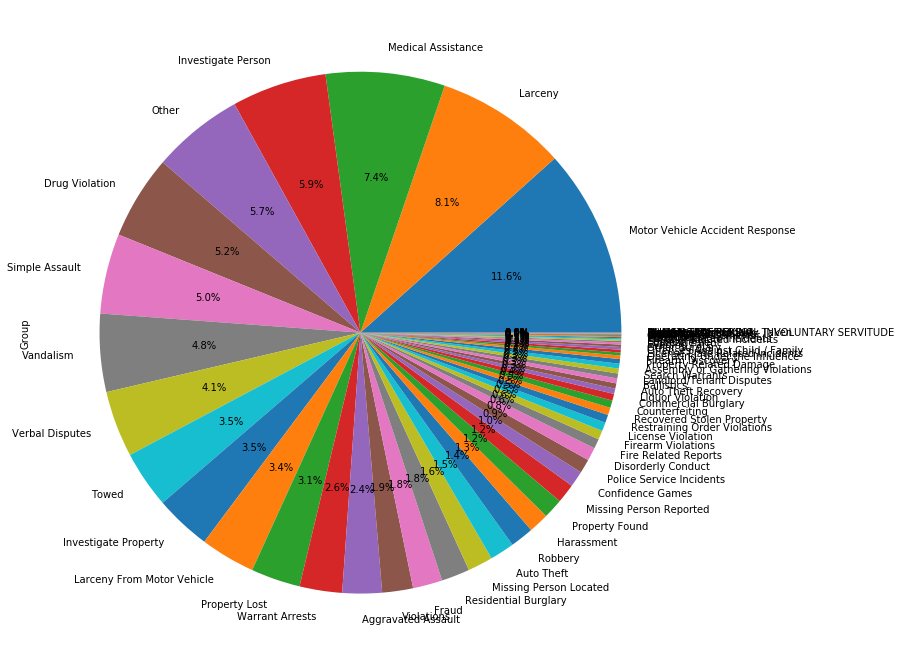

In [15]:
#pie chart
cb["Group"].value_counts().plot(kind="pie", figsize=(20, 12), autopct='%1.1f%%')

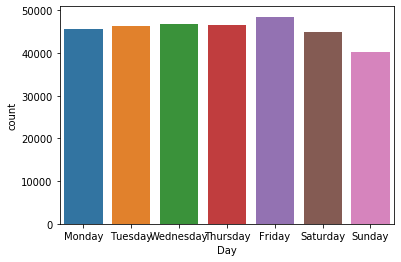

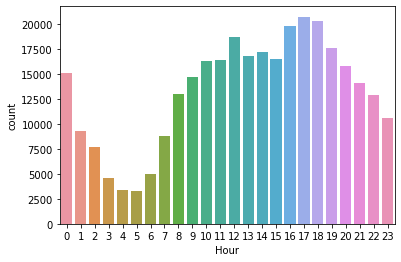

In [16]:
#plt.figure(figsize=(8,8)) # to adjust the graph size
sns.countplot(x=cb.Day)  
plt.show() 
    
sns.countplot(x=cb.Hour)  
plt.show() 

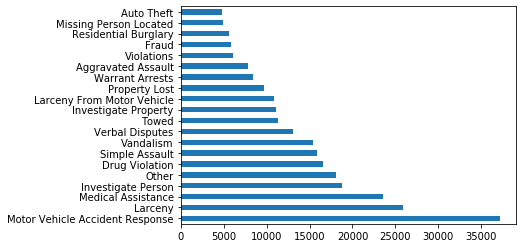

In [17]:
cb['Group'].value_counts()[:20].plot(kind='barh')

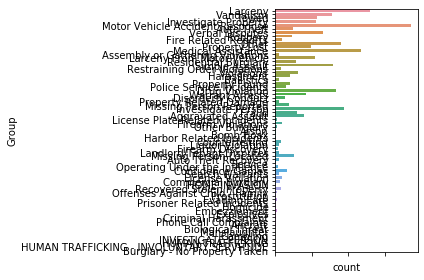

In [18]:
ax=sns.countplot(y="Group", data=cb)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

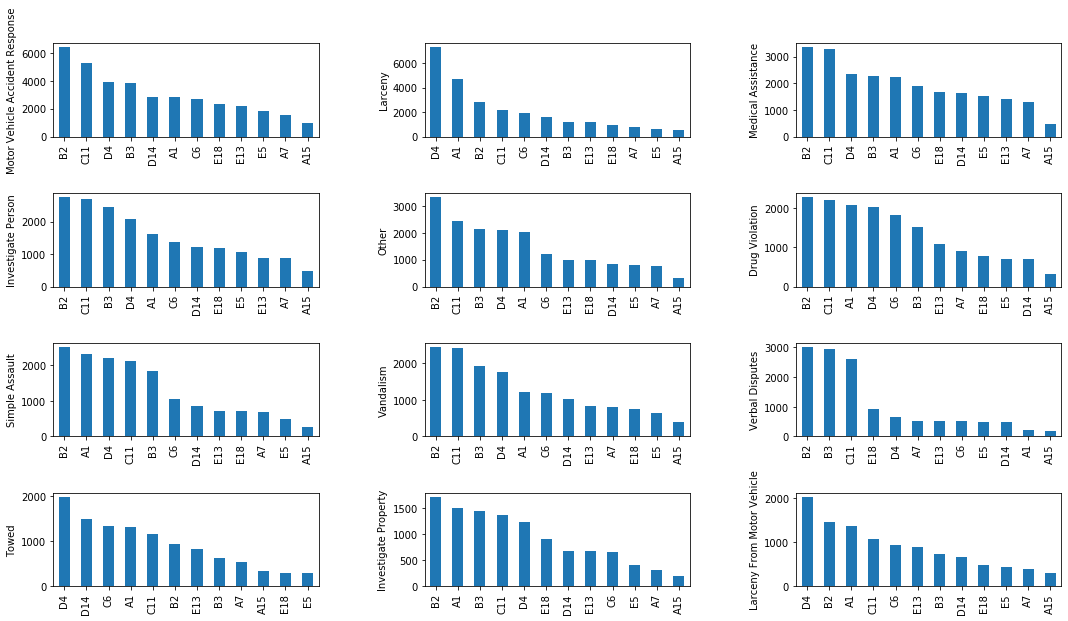

In [19]:
#Bar chart represents the visualization of the most common crime in each district
cat = [cb["Group"].value_counts().index[x] for x in range(12)]
fig, ax = plt.subplots(4, 3, figsize=(20, 10))
for var, subplot in zip(cat, ax.flatten()):
    cb[cb["Group"]==var]["District"].value_counts().plot(kind="bar",ax=subplot)
    subplot.set_ylabel(var)
fig.subplots_adjust(left=0.2, wspace=0.4, hspace = 0.6)

## 4) Interactive Mapping

In [20]:
# drop null rows
cb.dropna(subset=['Lat', 'Long', 'District'], inplace=True)
cb = cb[cb.Month==1]
cb = cb[cb.Year==2018]
cb = cb[cb.Hour==2]
cb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 53338 to 98459
Data columns (total 13 columns):
Group          179 non-null object
Description    179 non-null object
District       179 non-null object
Area           179 non-null object
Shooting       179 non-null object
Date           179 non-null datetime64[ns]
Year           179 non-null int64
Month          179 non-null int64
Day            179 non-null category
Hour           179 non-null int64
Street         177 non-null object
Lat            179 non-null float64
Long           179 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 18.7+ KB


In [21]:
# Create a map
m_1 = folium.Map(location=[42.32,-71.0589], tiles='openstreetmap', zoom_start=9)

# Display the map
m_1

In [22]:
# Create a map
m_2 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=13)

# Add points to the map
for idx, row in cb.iterrows():
    Marker([row['Lat'], row['Long']]).add_to(m_2)

# Display the map
m_2

In [23]:
# Create the map
m_3 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=13)


# Add points to the map
mc = MarkerCluster()
for idx, row in cb.iterrows():
    if not math.isnan(row['Long']) and not math.isnan(row['Lat']):
            popup_text = """<b><b>Group : {},
                            Description : {},
                            Date : <b><b>{}"""
            popup_text = popup_text.format(row['Group'],row['Description'],row['Date'] )

            mc.add_child(Marker([row['Lat'], row['Long']], popup= popup_text))

m_3.add_child(mc)

# Display the map
m_3

In [24]:
# Create a base map
m_4 = folium.Map(location=[42.32,-71.0589], tiles='cartodbdark_matter', zoom_start=13)

# Add a heatmap to the base map
HeatMap(data=cb[['Lat', 'Long']], radius=10).add_to(m_4)

# Display the map
m_4